<a href="https://colab.research.google.com/github/NachoPeinador/PIA-KRASv2-Nb/blob/main/PIA-KRASv2-Nb%20/MD_Simulation/MD_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar librerías para la simulación y el manejo de archivos PDB/CIF
print("Instalando OpenMM para la simulación...")
!pip install openmm &> /dev/null

print("Instalando PDBFixer para preparar la estructura...")
!pip install pdbfixer &> /dev/null

print("Instalando BioPython para la conversión de CIF a PDB...")
!pip install biopython &> /dev/null

print("Instalando py3Dmol para la visualización 3D...")
!pip install py3Dmol &> /dev/null

print("\n¡Instalación completada!")

Instalando OpenMM para la simulación...
Instalando PDBFixer para preparar la estructura...
Instalando BioPython para la conversión de CIF a PDB...
Instalando py3Dmol para la visualización 3D...

¡Instalación completada!


In [ ]:
# --- Celda 5: Instalación y Reinicio Forzado ---
print("Instalando todas las librerías necesarias...")
!pip install openmm pdbfixer biopython py3Dmol &> /dev/null
print("¡Instalación completada!")
print("\n!!! ACCIÓN REQUERIDA !!!")
print("El entorno se reiniciará ahora. Después del reinicio, NO vuelvas a ejecutar esta celda.")
print("Continúa con la celda que te he proporcionado como 'Paso B'.")

# Esta línea reinicia el kernel de Python, que es más limpio que un colapso.
import os
os.kill(os.getpid(), 9)

Instalando todas las librerías necesarias...


In [1]:
# --- Celda 6: Subir y Convertir (Post-Reinicio) ---
from google.colab import files
from Bio.PDB import MMCIFParser, PDBIO
import os

# Subir el archivo .cif
print("Por favor, selecciona de nuevo tu archivo .cif:")
uploaded = files.upload()
cif_filename = list(uploaded.keys())[0]
print(f"Archivo '{cif_filename}' subido.")

# Convertir a .pdb
pdb_filename = "protein.pdb"
print(f"Convirtiendo '{cif_filename}' a '{pdb_filename}'...")
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("alphafold_structure", cif_filename)
io = PDBIO()
io.set_structure(structure)
io.save(pdb_filename)
print("¡Conversión completada!")

Por favor, selecciona de nuevo tu archivo .cif:


Saving fold_2025_07_18_13_00_model_0.cif to fold_2025_07_18_13_00_model_0.cif
Archivo 'fold_2025_07_18_13_00_model_0.cif' subido.
Convirtiendo 'fold_2025_07_18_13_00_model_0.cif' a 'protein.pdb'...
¡Conversión completada!


In [2]:
# --- Celda de Preparación (Versión Corregida Definitiva) ---

print("--- Iniciando preparación del sistema (método alternativo con OpenMM Modeller) ---")

from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout

# Nos aseguramos de que el archivo PDB de la conversión exista
pdb_filename = "protein.pdb"

try:
    # Paso 1: Cargar la estructura directamente desde el PDB convertido
    print(f"Paso 1: Cargando estructura desde '{pdb_filename}'...")
    pdb = PDBFile(pdb_filename)

    # Paso 2: Crear un "Modeller" y definir el campo de fuerza
    modeller = Modeller(pdb.topology, pdb.positions)
    forcefield = ForceField('amber14-all.xml', 'amber14/tip3p.xml')
    print("Campo de fuerza cargado.")

    # Paso 3: Añadir los hidrógenos faltantes
    print("Paso 3: Añadiendo hidrógenos faltantes usando OpenMM Modeller...")
    modeller.addHydrogens(forcefield, pH=7.4)
    print("Hidrógenos añadidos con éxito.")

    # Paso 4: Añadir la caja de agua y los iones
    print("\nPaso 4: Añadiendo solvente e iones...")
    modeller.addSolvent(forcefield, padding=1.0*nanometer, model='tip3p')
    print("Solvente añadido.")

    # ¡AQUÍ ESTÁ LA CORRECCIÓN! Usamos "addExtraParticles" para añadir los iones.
    print("Añadiendo iones para neutralizar...")
    modeller.addExtraParticles(forcefield)
    print("Iones añadidos.")

    # Guardamos el sistema final
    final_pdb_filename = 'protein_system.pdb'
    PDBFile.writeFile(modeller.topology, modeller.positions, open(final_pdb_filename, 'w'))
    print(f"Sistema final guardado en '{final_pdb_filename}'.")

    # Paso 5: Crear el objeto System de OpenMM para la simulación
    print("\nPaso 5: Creando el sistema de OpenMM...")
    system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
            nonbondedCutoff=1.0*nanometer, constraints=HBonds)

    print("\n¡Preparación del sistema completada!")

except Exception as e:
    print(f"\nOcurrió un error durante la preparación: {e}")
    print("Verifica que el archivo 'protein.pdb' se generó correctamente en el paso de conversión.")

--- Iniciando preparación del sistema (método alternativo con OpenMM Modeller) ---
Paso 1: Cargando estructura desde 'protein.pdb'...
Campo de fuerza cargado.
Paso 3: Añadiendo hidrógenos faltantes usando OpenMM Modeller...
Hidrógenos añadidos con éxito.

Paso 4: Añadiendo solvente e iones...
Solvente añadido.
Añadiendo iones para neutralizar...
Iones añadidos.
Sistema final guardado en 'protein_system.pdb'.

Paso 5: Creando el sistema de OpenMM...

¡Preparación del sistema completada!


In [3]:
# --- Celda Final: Minimización, Equilibrado y Producción ---
print("--- Iniciando la simulación de Dinámica Molecular ---")

# --- Paso 1: Configurar la simulación ---
# El Integrador define cómo se actualizan las posiciones y velocidades en cada paso de tiempo.
# Usamos un LangevinIntegrator, que es bueno para mantener la temperatura constante (termostato).
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 2*femtoseconds)

# La plataforma indica dónde se ejecutará la simulación.
# Intentamos usar la GPU ('CUDA' o 'OpenCL') que es mucho más rápida. Si no, usa la CPU.
try:
    platform = Platform.getPlatformByName('CUDA')
    properties = {'CudaPrecision': 'mixed'}
    print("Plataforma de simulación: CUDA (GPU)")
except Exception:
    try:
        platform = Platform.getPlatformByName('OpenCL')
        properties = {'OpenCLPrecision': 'mixed'}
        print("Plataforma de simulación: OpenCL (GPU)")
    except Exception:
        platform = Platform.getPlatformByName('CPU')
        properties = {}
        print("Plataforma de simulación: CPU")


# El objeto 'Simulation' une todo: topología, sistema, integrador y plataforma.
simulation = Simulation(modeller.topology, system, integrator, platform, properties)

# Asignamos las posiciones iniciales (las que preparamos en la celda anterior)
simulation.context.setPositions(modeller.positions)
print("Configuración de la simulación completada.")


# --- Paso 2: Minimización de Energía ---
print("\nPaso 2: Minimizando la energía del sistema...")
simulation.minimizeEnergy()
print("Minimización completada.")


# --- Paso 3: Equilibrado y Producción ---
# Configuramos los "reporteros", que son los encargados de guardar los datos.
# Guardaremos datos cada 1000 pasos (equivalente a 2 ps).
report_interval = 1000

# Reportero para mostrar el progreso en la pantalla
simulation.reporters.append(StateDataReporter(stdout, report_interval, step=True,
        potentialEnergy=True, temperature=True, progress=True, remainingTime=True,
        speed=True, totalSteps=500000, separator='\t'))

# Reportero para guardar la trayectoria (los movimientos) en un archivo .dcd
# Guardaremos 500 ps de simulación (250,000 pasos * 2 fs/paso)
simulation.reporters.append(DCDReporter('trajectory.dcd', report_interval))
print("\nReporteros configurados. La simulación de producción comenzará ahora.")
print("Esto puede tardar varios minutos...")


# ¡Ejecutamos la simulación!
# 500,000 pasos con un paso de tiempo de 2 fs nos dan 1 nanosegundo (ns) de simulación.
# Para una prueba rápida, usamos 250,000 pasos (500 picosegundos).
# Puedes aumentar este número para una simulación más larga.
simulation.step(250000)


print("\n\n¡SIMULACIÓN COMPLETADA!")

--- Iniciando la simulación de Dinámica Molecular ---
Plataforma de simulación: OpenCL (GPU)
Configuración de la simulación completada.

Paso 2: Minimizando la energía del sistema...
Minimización completada.

Reporteros configurados. La simulación de producción comenzará ahora.
Esto puede tardar varios minutos...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
0.2%	1000	-393495.8174483862	250.4178752569779	0	--
0.4%	2000	-374307.9401208728	287.4590009639653	165	8:41
0.6%	3000	-369051.7455557438	297.47088644528475	166	8:38
0.8%	4000	-368325.26619979786	298.3989767034569	165	8:39
1.0%	5000	-368345.6484733997	300.85405414412486	165	8:37
1.2%	6000	-367458.7987430929	298.69612273527713	165	8:37
1.4%	7000	-366190.3042011808	301.1491248836676	165	8:37
1.6%	8000	-366832.99672896275	302.61288654790894	164	8:39
1.8%	9000	-366983.0591881857	302.5884219207105	162	8:45
2.0%	10000	-367210.33351093903	301.73491052522814	158	8:55
2.2%	11000	-3665

In [4]:
from google.colab import files

print("Descargando el archivo de topología/estructura inicial...")
files.download('protein_system.pdb')

print("\nDescargando el archivo de trayectoria...")
files.download('trajectory.dcd')

Descargando el archivo de topología/estructura inicial...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Descargando el archivo de trayectoria...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Instalando MDTraj para el análisis de la trayectoria...
¡Instalación completada!

Cargando la estructura y la trayectoria...
Trayectoria cargada: 250 fotogramas, 28471 átomos.
Selección de KRAS (Cadena A): 1800 átomos.
Selección del Nanobody (Cadena B): 148 átomos.

Alineando la trayectoria y calculando el RMSD...
Cálculo de RMSD completado.

Generando el gráfico de RMSD...
Gráfico guardado como 'rmsd_plot.png'


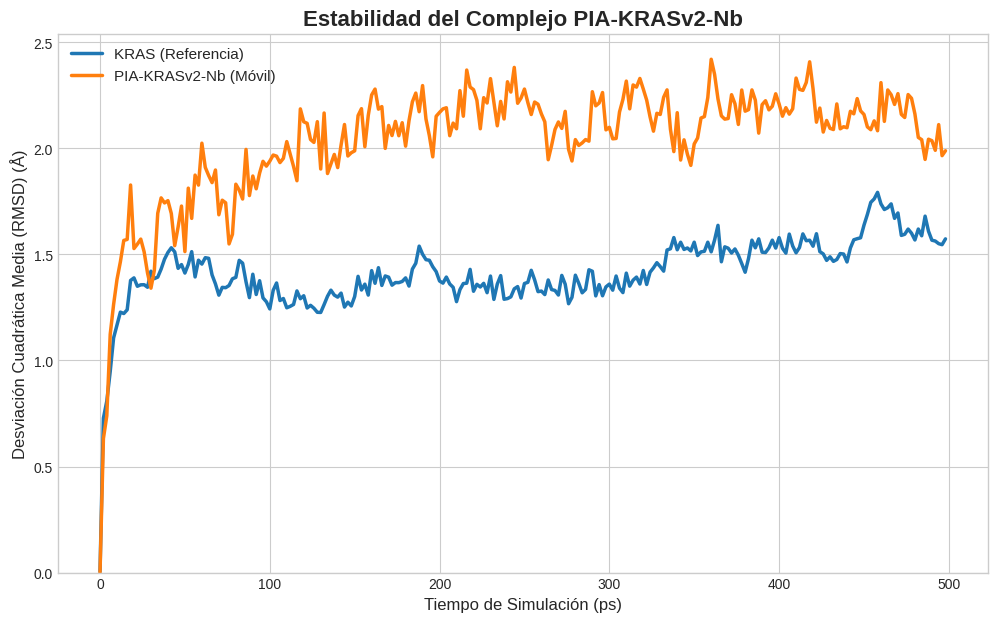

In [5]:
# --- Paso 1: Instalar la librería de análisis MDTraj ---
print("Instalando MDTraj para el análisis de la trayectoria...")
!pip install mdtraj &> /dev/null
print("¡Instalación completada!")


# --- Paso 2: Importar librerías y cargar los archivos ---
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import os

# Nombres de los archivos que generamos
pdb_file = 'protein_system.pdb'
traj_file = 'trajectory.dcd'

if not os.path.exists(pdb_file) or not os.path.exists(traj_file):
    print("\n¡Error! No se encuentran los archivos 'protein_system.pdb' o 'trajectory.dcd'.")
    print("Asegúrate de haber ejecutado la celda de simulación con éxito.")
else:
    print("\nCargando la estructura y la trayectoria...")
    # Cargamos la trayectoria completa usando el PDB como topología
    traj = md.load(traj_file, top=pdb_file)
    print(f"Trayectoria cargada: {traj.n_frames} fotogramas, {traj.n_atoms} átomos.")


    # --- Paso 3: Definir las selecciones (KRAS y Nanobody) ---
    # OpenMM Modeller suele nombrar las cadenas como A, B, etc. Asumimos que
    # KRAS es la primera cadena (chainid 0) y el Nanobody la segunda (chainid 1).
    kras_indices = traj.topology.select('protein and chainid 0')
    nanobody_indices = traj.topology.select('protein and chainid 1')

    if len(kras_indices) == 0 or len(nanobody_indices) == 0:
        print("\n¡Error en la selección! No se pudieron encontrar ambas cadenas de proteína.")
        print("Es posible que las IDs de las cadenas no sean 0 y 1. Se detiene el análisis.")
    else:
        print(f"Selección de KRAS (Cadena A): {len(kras_indices)} átomos.")
        print(f"Selección del Nanobody (Cadena B): {len(nanobody_indices)} átomos.")

        # --- Paso 4: Alinear la trayectoria y calcular RMSD ---
        print("\nAlineando la trayectoria y calculando el RMSD...")
        # Alinear cada fotograma con el primero, usando solo el esqueleto de KRAS como referencia
        # para ver cómo se mueve el Nanobody con respecto a él.
        reference_indices = traj.topology.select('protein and chainid 0 and backbone')
        traj.superpose(traj, frame=0, atom_indices=reference_indices)

        # Calcular el RMSD para cada selección. El resultado está en nm.
        rmsd_kras = md.rmsd(traj, traj, frame=0, atom_indices=kras_indices)
        rmsd_nanobody = md.rmsd(traj, traj, frame=0, atom_indices=nanobody_indices)

        # Convertir de nanómetros (nm) a Angstroms (Å) para la publicación
        rmsd_kras_A = rmsd_kras * 10
        rmsd_nanobody_A = rmsd_nanobody * 10
        print("Cálculo de RMSD completado.")


        # --- Paso 5: Generar el gráfico ---
        print("\nGenerando el gráfico de RMSD...")
        # Crear un eje de tiempo en picosegundos (ps)
        total_time_ps = 500
        time_ps = np.arange(traj.n_frames) * (total_time_ps / traj.n_frames)

        plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráfico profesional
        plt.figure(figsize=(12, 7))

        plt.plot(time_ps, rmsd_kras_A, label='KRAS (Referencia)', linewidth=2.5)
        plt.plot(time_ps, rmsd_nanobody_A, label='PIA-KRASv2-Nb (Móvil)', linewidth=2.5)

        plt.title('Estabilidad del Complejo PIA-KRASv2-Nb', fontsize=16, fontweight='bold')
        plt.xlabel('Tiempo de Simulación (ps)', fontsize=12)
        plt.ylabel('Desviación Cuadrática Media (RMSD) (Å)', fontsize=12)
        plt.legend(fontsize=11)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.ylim(bottom=0) # Asegurar que el eje Y empiece en 0

        # Guardar el gráfico en un archivo
        plt.savefig('rmsd_plot.png', dpi=300, bbox_inches='tight')
        print("Gráfico guardado como 'rmsd_plot.png'")

        plt.show()